In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import sklearn

plt.style.use('seaborn')
np.__version__

/tmp/ipykernel_71430/499523765.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'1.24.4'

In [2]:
df = pd.read_csv('./Data/data.csv').drop(columns=['Index'], axis=0)
df.head()

,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1


<Axes: xlabel='Age', ylabel='Count'>

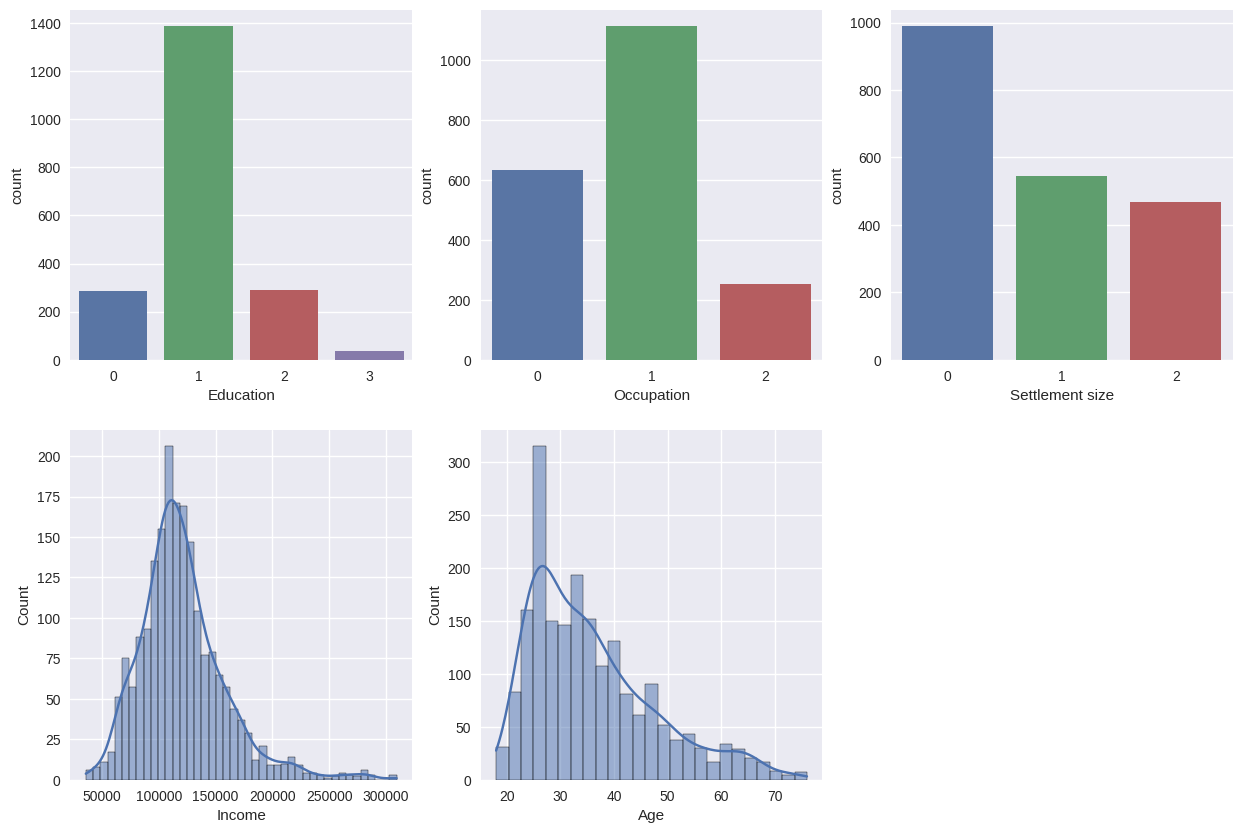

In [3]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 3, 1)
sea.countplot(x = df['Education'])

plt.subplot(2, 3, 2)
sea.countplot(x = df['Occupation'])

plt.subplot(2, 3, 3)
sea.countplot(x = df['Settlement size'])

plt.subplot(2, 3, 4)
sea.histplot(x = df['Income'], kde= True)

plt.subplot(2, 3, 5)
sea.histplot(x = df['Age'], kde= True)


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Data preprocessing

df[['Age', 'Income']] = scaler.fit_transform(df[['Age', 'Income']].values)
df['Education'] = df['Education'] - 1
# df = pd.concat([df, pd.get_dummies(df['Settlement size']).astype(np.int32)], axis=1)
# df = df.drop(columns=['Settlement size'], axis=0)

df


,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0.844828,1,0.324781,1,2
1,1,1,0.068966,0,0.420210,1,2
2,0,0,0.534483,0,0.195144,0,0
3,0,0,0.465517,0,0.496223,1,1
4,0,0,0.603448,0,0.413842,1,1
...,...,...,...,...,...,...,...
1995,1,0,0.500000,0,0.320595,0,0
1996,1,1,0.155172,0,0.299460,1,0
1997,0,0,0.224138,-1,0.184871,0,0
1998,1,1,0.103448,0,0.227162,0,0


In [5]:
X_customer = df.values
X_customer

array([[0.        , 0.        , 0.84482759, ..., 0.32478101, 1.        ,
        2.        ],
       [1.        , 1.        , 0.06896552, ..., 0.42021043, 1.        ,
        2.        ],
       [0.        , 0.        , 0.53448276, ..., 0.19514353, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.22413793, ..., 0.18487051, 0.        ,
        0.        ],
       [1.        , 1.        , 0.10344828, ..., 0.22716172, 0.        ,
        0.        ],
       [0.        , 0.        , 0.12068966, ..., 0.11912317, 0.        ,
        0.        ]])

In [6]:
class GMM:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.tolerance = 1e-4
        self.log_likelihood = []
    
    # initialize the parameters (weights, covariance, means)
    def initialize_parameters(self, c, k):
        # means = (n_clusters, n_features, 1)
        # covariance = (n_clusters, n_features, n_features)
        # weights = (n_clusters, 1)
        self.parameters = c * k + c * k * k + c
        
        return (
            np.random.uniform(0, 1, (c, k)),
            np.array([np.eye(k) for _ in range(c)]), 
            np.ones(self.n_clusters)/self.n_clusters
        )
    
    # to calculate pdf of multivariate normal
    def multivariate_normal(self, X, means, covariance):
        d = self.X.shape[1]
        exponent = -0.5 * (X - means).T @ np.linalg.inv(covariance) @ (X - means)
        constant = 1/(((2 * np.pi) ** (d/2)) * (np.linalg.det(covariance) ** 0.5))
        return np.exp(exponent) * constant
        
    # to perform the E step
    def expectation(self, ):
        responsibilities = np.zeros((self.X.shape[0], self.n_clusters))
        
        for i in range(self.X.shape[0]):
            for j in range(self.n_clusters):
                responsibilities[i, j] = self.weights[j] * self.multivariate_normal(self.X[i], self.means[j], self.covariance[j])
                
            responsibilities[i] = responsibilities[i]/np.sum(responsibilities[i])
        
        return responsibilities
        
    # to perform the M step
    def maximization(self, responsibilities):
        d = self.X.shape[1]
        
        for j in range(self.n_clusters):
            Nk = np.sum(responsibilities[:, j])
            self.means[j] = np.sum(self.X * responsibilities[:, j][:, np.newaxis], axis=0)/Nk
            self.covariance[j] = ((self.X - self.means[j]).T @ ((self.X - self.means[j]) * responsibilities[:, j][:, np.newaxis]))/Nk
            self.covariance[j] += np.eye(d) * 1e-6
        
        self.weights = np.mean(responsibilities, axis=0)      
    
    # to calculate the log likelihood
    def calculate_log_likelihood(self):
        n, ll = len(self.X), 0
                
        for i in range(n):
            l = 0
            for j in range(self.n_clusters):
                l += self.weights[j] * self.multivariate_normal(self.X[i], self.means[j], self.covariance[j])
            ll += np.log(l)
            
        return ll            
    
    # fit the gmm model
    def fit(self, X, epochs = 100):
        self.X = X
        self.means, self.covariance, self.weights = self.initialize_parameters(self.n_clusters, self.X.shape[1])
       
        for i in tqdm(range(epochs)):
                
            last_means, last_covariance, last_weights = self.means.copy(), self.covariance.copy(), self.weights.copy()
            
            responsibilities = self.expectation()
            self.maximization(responsibilities=responsibilities)
            
            self.log_likelihood.append(self.calculate_log_likelihood())
            
            means_diff = np.mean(np.abs(self.means - last_means))
            covariance_diff = np.mean(np.abs(self.covariance - last_covariance))
            weights_diff = np.mean(np.abs(self.weights - last_weights))
                
            if means_diff < self.tolerance and covariance_diff < self.tolerance and weights_diff < self.tolerance:
                print("Convergence done")
                break 
        
        clusters = np.argmax(responsibilities, axis = 1)
        return clusters
    
    
gmm = GMM(n_clusters=5)

clusters = gmm.fit(X_customer, epochs=100)


  0%|          | 0/100 [00:00<?, ?it/s]

Convergence done


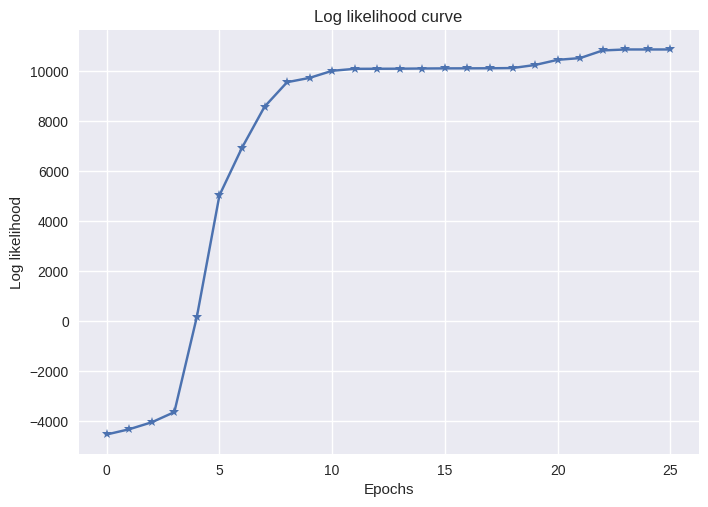

In [7]:
plt.title('Log likelihood curve')
plt.xlabel('Epochs')
plt.ylabel('Log likelihood')
plt.plot(gmm.log_likelihood, marker = '*')

In [8]:
print("Weights:", gmm.weights)
print("Means:", gmm.means)
print("Covariances:", gmm.covariance)

Weights: [0.05750205 0.11945411 0.029001   0.72602136 0.06802147]
Means: [[ 0.27825093  0.72174907  0.18111344 -0.27825093  0.21126231  0.47823707
   0.        ]
 [ 0.5357706   0.4642294   0.2444865   0.          0.27731928  0.75726074
   0.74013641]
 [ 0.31033414  0.68966586  0.56926388  1.03448146  0.35991541  0.68969171
   0.44832911]
 [ 0.42908016  0.42908016  0.31860958 -0.02064948  0.31361085  0.80993861
   0.69080988]
 [ 0.83030599  1.          0.31357697  0.57321556  0.40863958  1.24237236
   2.        ]]
Covariances: [[[ 2.00828348e-01 -2.00827348e-01 -6.16867779e-03 -2.00827348e-01
   -9.55727450e-03 -5.48118352e-02  0.00000000e+00]
  [-2.00827348e-01  2.00828348e-01  6.16867779e-03  2.00827348e-01
    9.55727450e-03  5.48118352e-02  0.00000000e+00]
  [-6.16867779e-03  6.16867779e-03  8.21263933e-03  6.16867779e-03
    5.56370917e-04 -5.62620621e-04  0.00000000e+00]
  [-2.00827348e-01  2.00827348e-01  6.16867779e-03  2.00828348e-01
    9.55727450e-03  5.48118352e-02  0.000000

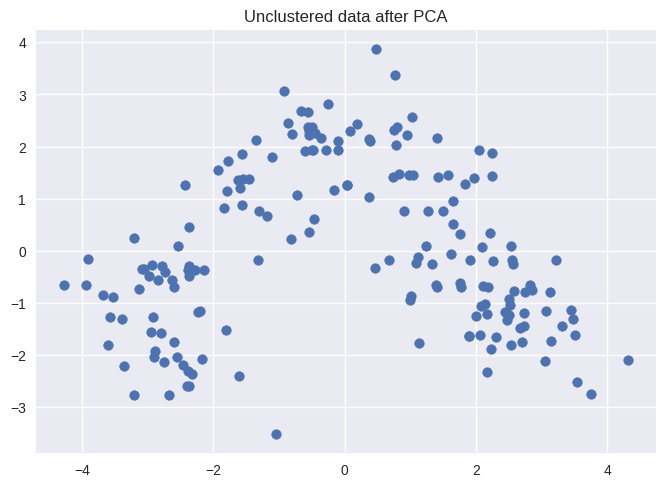

In [9]:
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

wine = load_wine().data
pca = PCA(n_components=2)
scaler = StandardScaler()

wine = scaler.fit_transform(wine)

wine_2 = pca.fit_transform(wine)

plt.scatter(x = wine_2[:, 0], y = wine_2[:, 1])
plt.title('Unclustered data after PCA')
plt.show()

In [10]:
gmm = GMM(n_clusters=3)
gmm_clusters = gmm.fit(wine_2)
gmm_clusters


  0%|          | 0/100 [00:00<?, ?it/s]

Convergence done


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

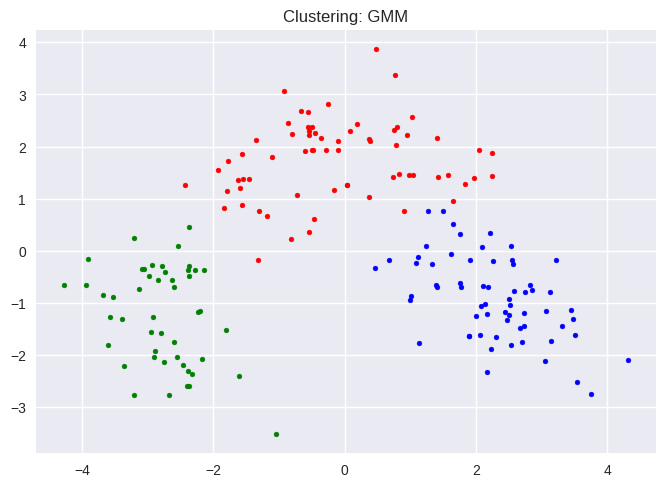

In [11]:
colors = ['red', 'green', 'blue']
for i in np.unique(gmm_clusters):
    indices = gmm_clusters == i
    plt.scatter(wine_2[indices][:, 0], wine_2[indices][:, 1], color=colors[i], marker='.')

plt.title('Clustering: GMM')
plt.show()

In [12]:
def AIC_BIC(max_clusters = 10):
    aic, bic = [], []
    for i in range(1, max_clusters + 1):
        gmm = GMM(n_clusters=i)
        gmm.fit(wine_2)
        aic.append(-2 * gmm.log_likelihood[-1] + 2 * gmm.parameters)
        bic.append(-2 * gmm.log_likelihood[-1] + gmm.parameters * np.log(len(wine_2)))
    
    return aic, bic

aic, bic = AIC_BIC()


  0%|          | 0/100 [00:00<?, ?it/s]

Convergence done


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Convergence done


  0%|          | 0/100 [00:00<?, ?it/s]

Convergence done


  0%|          | 0/100 [00:00<?, ?it/s]

Convergence done


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Convergence done


  0%|          | 0/100 [00:00<?, ?it/s]

Convergence done


  0%|          | 0/100 [00:00<?, ?it/s]

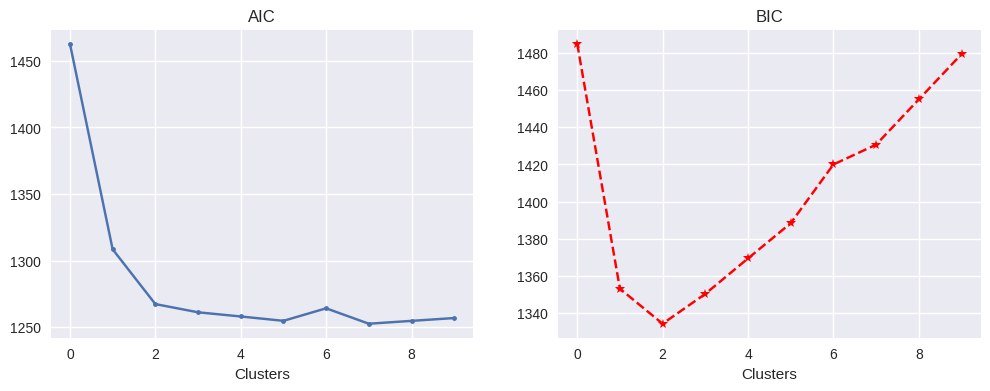

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.title('AIC')
plt.xlabel('Clusters')
plt.plot(aic, marker='.')

plt.subplot(1,2,2)
plt.title('BIC')
plt.xlabel('Clusters')
plt.plot(bic, 'r--*')


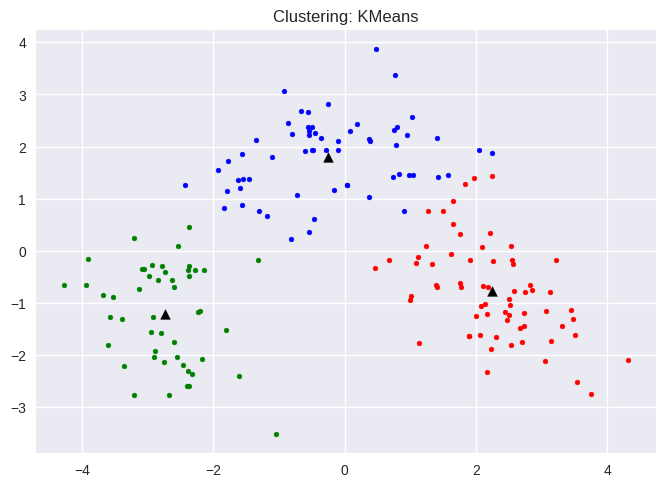

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(wine_2)
kmeans_clusters = kmeans.predict(wine_2)

colors = ['red', 'green', 'blue']
for i in np.unique(kmeans_clusters):
    indices = kmeans_clusters == i
    plt.scatter(wine_2[indices][:, 0], wine_2[indices][:, 1], color=colors[i], marker='.')
    plt.scatter(*kmeans.cluster_centers_[i], color='black', marker='^')
    
plt.title('Clustering: KMeans')
plt.show()

In [15]:
from sklearn.metrics import silhouette_score

gmm_score = silhouette_score(wine_2, gmm_clusters)
kmeans_score = silhouette_score(wine_2, kmeans_clusters)

print("Silhoutte Scores:\n")
print("GMM:", gmm_score)
print("KMeans:", kmeans_score)

Silhoutte Scores:

GMM: 0.5581473461293222
KMeans: 0.5609305721582906
